# Semestrální projekt, Využití Umělých Neuronových Sítí při kompresi dat
- Student: Petr Ptáček, PTA0054
- Vedoucí práce: Ing. Michal Vašinek Ph.D.

## Importy knihoven

In [61]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import time
import string
import random
import sys
import decimal

# Pandas dataframes
import pandas as pd
# Numpy
import numpy as np 
# Tensorflow 2.10.0
import tensorflow as tf
from tensorflow.keras.utils import Sequence


# scikit-learn
import sklearn
from sklearn.model_selection import train_test_split

# Graphing
import matplotlib
from matplotlib import pyplot as plt

# Packages for manipulation with images
from PIL import Image

#
import functools

In [2]:
# check if gpu is ready to use
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
tf.sysconfig.get_build_info() 

OrderedDict([('cpu_compiler', '/dt9/usr/bin/gcc'),
             ('cuda_compute_capabilities',
              ['sm_35', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'compute_80']),
             ('cuda_version', '11.2'),
             ('cudnn_version', '8'),
             ('is_cuda_build', True),
             ('is_rocm_build', False),
             ('is_tensorrt_build', True)])

In [9]:
# Set logging level only to ERROR
tf.get_logger().setLevel("ERROR")

## Funkce

In [10]:
# Load alphabet of all files which meet the pattern.
"""
def load_alphabet(pattern: str) -> set():
     # list files in folder
    filenames = tf.data.Dataset.list_files(pattern,)
    alphabet = set()
    # For each file in folder
    for filename in filenames:
        # read whole file
        with open(filename.numpy(), mode="r", encoding="ISO-8859-1") as file:
            text = file.read()
             # insert the list to the set
            alphabet = alphabet.union(set(text))
            del text

    return alphabet
"""

'\ndef load_alphabet(pattern: str) -> set():\n     # list files in folder\n    filenames = tf.data.Dataset.list_files(pattern,)\n    alphabet = set()\n    # For each file in folder\n    for filename in filenames:\n        # read whole file\n        with open(filename.numpy(), mode="r", encoding="ISO-8859-1") as file:\n            text = file.read()\n             # insert the list to the set\n            alphabet = alphabet.union(set(text))\n            del text\n\n    return alphabet\n'

In [11]:
def create_test_data(filename: str, alphabet: [str], size: int = 100_000):
    with open(filename, mode="w") as file:
        for i in range(0, size):
            file.write(alphabet[i % len(alphabet)])
    

In [12]:
def calculate_accuracy(pred_y, data_y):
    right = 0
    for i in range(0, len(pred_y)):
        right += 1 if list(test_y[i])[0] == int.to_bytes(int(np.argmax(pred_y[i])), length=1, byteorder="big") else 0 
    return right / len(pred_y)

In [13]:
def load_data_binary(pattern: str, shuffle: bool = False, seed:int = None, lengthOfSubstring: int = 3, portion: float = 0.5) -> ([],[]):
    train_x = []
    train_y = []
    
    # Get list of filenames from pattern
    filenames = tf.data.Dataset.list_files(pattern, shuffle=shuffle, seed=seed)
    filenames = [i.numpy() for i in filenames]
    filenames = random.sample(filenames, int(len(filenames) * portion))
    #print(filenames)
    # Set initial file_index and position in file.
    position_in_file = 0
    file_index = 0
    
    print(f'Loading gutenberg dataset [{round( (file_index) / len(filenames) * 100, 1)} %]\r', end="")
    # File Loop
    while file_index < len(filenames):
        # Open File
        with open(filenames[file_index], mode="rb") as file:
            file.seek(position_in_file)
            byte_x = [file.read(1) for i in range(0, lengthOfSubstring)] #file.read(lengthOfSubstring)
            byte_y = [file.read(1)]
            # Main read loop
            while True:
                # If end of file
                if b'' in byte_x or b'' in byte_y:
                    file_index += 1
                    position_in_file = 0
                    break
                else:
                    train_x.append(byte_x)
                    train_y.append(byte_y)
                    # Read like this: "Hello world!" -> ("Hel","l"), ("ell","o"), ("llo"," "), ...
                    position_in_file += 1
                    file.seek(position_in_file)
                    byte_x = [file.read(1) for i in range(0, lengthOfSubstring)] #file.read(lengthOfSubstring)
                    byte_y = [file.read(1)]
        print(f'Loading gutenberg dataset [{round( (file_index) / len(filenames) * 100, 1)} %]\r', end="")
                    
    return train_x, train_y



In [14]:
# Deprecated
# Load data from files into train_x and train_y np arrays in format "tex" -> "t", "ext" -> "u", "xtu" -> "r", "tur" -> "e", ... 
"""
def load_data(pattern: str, shuffle: bool = False, seed:int = None, lengthOfSubstring: int = 3, removeDuplicates:bool = False) -> ([],[]):
    # list files in folder
    filenames = tf.data.Dataset.list_files(pattern, shuffle=shuffle, seed=seed)
    data = []
    # For each file in folder
    for filename in filenames:
        # read whole file
        with open(filename.numpy(), mode="r", encoding="ISO-8859-1") as file:
            #print(filename.numpy())
            text = file.read()

            for i in range(0, len(text)-lengthOfSubstring):
                #index = np.random.randint(low=0, high=len(text))
                index = i
                x = text[index:index + lengthOfSubstring]
                y = text[index + lengthOfSubstring]
                
                data.append((x, y))
            del text
        # Remove duplicates
        if removeDuplicates:
            data = list(dict.fromkeys(data))
    
    data_x = [x[0] for x in data]
    data_y = [x[1] for x in data]
    del data
    return np.array(data_x), np.array(data_y)
"""

'\ndef load_data(pattern: str, shuffle: bool = False, seed:int = None, lengthOfSubstring: int = 3, removeDuplicates:bool = False) -> ([],[]):\n    # list files in folder\n    filenames = tf.data.Dataset.list_files(pattern, shuffle=shuffle, seed=seed)\n    data = []\n    # For each file in folder\n    for filename in filenames:\n        # read whole file\n        with open(filename.numpy(), mode="r", encoding="ISO-8859-1") as file:\n            #print(filename.numpy())\n            text = file.read()\n\n            for i in range(0, len(text)-lengthOfSubstring):\n                #index = np.random.randint(low=0, high=len(text))\n                index = i\n                x = text[index:index + lengthOfSubstring]\n                y = text[index + lengthOfSubstring]\n                \n                data.append((x, y))\n            del text\n        # Remove duplicates\n        if removeDuplicates:\n            data = list(dict.fromkeys(data))\n    \n    data_x = [x[0] for x in data]\n  

In [15]:
# String vectorizer function which hot encode each character into vector of 0/1 of size of alphabete
"""
def string_vectorizer(strng: str, alphabet: set() =string.ascii_lowercase) -> [[int]]:
    vector = [[0 if char != letter else 1 for char in alphabet] for letter in strng]
    return vector
"""

'\ndef string_vectorizer(strng: str, alphabet: set() =string.ascii_lowercase) -> [[int]]:\n    vector = [[0 if char != letter else 1 for char in alphabet] for letter in strng]\n    return vector\n'

In [16]:
def get_alphabet(data_x, data_y):
    alp = set()
    for y in data_y:
        for _y in y:
            alp.add(_y)
    for x in data_x:
        for _x in x:
            alp.add(_x)
    return alp

In [17]:
def show_history(history):
    plt.figure()
    for key in history.history.keys():
        plt.plot(history.epoch, history.history[key], label=key)
    plt.legend()
    plt.tight_layout()

## Třídy

In [18]:
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        # From bytes to Int in range <0, 255>
        batch_x = np.array([[int.from_bytes(x, "big") for x in batch_x[i]] for i in range(0, len(batch_x))])
        batch_y = np.array([[int.from_bytes(y, "big") for y in batch_y[i]] for i in range(0, len(batch_y))])
        
        # From integers to vectors of size 256, one hot encoding
        batch_x = np.array([tf.keras.utils.to_categorical(x, num_classes=256) for x in batch_x])
        batch_y = np.array([tf.keras.utils.to_categorical(y, num_classes=256) for y in batch_y])
        
        # Return sizes are (batch_size, 3, 256), (batch_size, 1, 256)
        return batch_x, batch_y

In [162]:
def float2bin(float_num, num_bits=None):
    """
    Converts a floating-point number into binary.
    float_num: The floating-point number. 
    num_bits: The number of bits expected in the result. If None, then the number of bits depends on the number.
    Returns the binary representation of the number.
    """

    float_num = str(float_num)
    if float_num.find(".") == -1:
        # No decimals in the floating-point number.
        integers = float_num
        decimals = ""
    else:
        integers, decimals = float_num.split(".")
    decimals = "0." + decimals
    decimals = Decimal(decimals)
    integers = int(integers)

    result = ""
    num_used_bits = 0
    while True:
        mul = decimals * 2
        int_part = int(mul)
        result = result + str(int_part)
        num_used_bits = num_used_bits + 1

        decimals = mul - int(mul)
        if type(num_bits) is type(None):
            if decimals == 0:
                break
        elif num_used_bits >= num_bits:
            break
    if type(num_bits) is type(None):
        pass
    elif len(result) < num_bits:
        num_remaining_bits = num_bits - len(result)
        result = result + "0"*num_remaining_bits

    integers_bin = bin(integers)[2:]
    result = str(integers_bin) + "." + str(result)
    return result

def bin2float(bin_num):
    """
    Converts a binary number to a floating-point number.
    bin_num: The binary number as a string.
    Returns the floating-point representation.
    """

    if bin_num.find(".") == -1:
        # No decimals in the binary number.
        integers = bin_num
        decimals = ""
    else:
        integers, decimals = bin_num.split(".")
    result = Decimal(0.0)

    # Working with integers.
    for idx, bit in enumerate(integers):
        if bit == "0":
            continue
        mul = 2**idx
        result = result + Decimal(mul)

    # Working with decimals.
    for idx, bit in enumerate(decimals):
        if bit == "0":
            continue
        mul = Decimal(1.0)/Decimal((2**(idx+1)))
        result = result + mul
    return result

In [ ]:
class ArithmeticBinaryCoder:
    def __init__(self, probability_table):
        """
        probability_table: Table as dictionary where key is the byte from alphabet <0, 255> and the valus is the probability
        """
        self.probability_table = probability_table
        
    def process_stage(self, stage_min_bin, stage_max_bin):
        """
        Processing a stage in the encoding/decoding process.
        stage_min_bin: The minimum binary number in the current stage.
        stage_max_bin: The maximum binary number in the current stage.
        Returns the probabilities of the terms in this stage. There are only 2 terms.
        """

        stage_mid_bin = stage_min_bin + "1"
        stage_min_bin = stage_min_bin + "0"

        stage_probs = {}
        stage_probs[0] = [stage_min_bin, stage_mid_bin]
        stage_probs[1] = [stage_mid_bin, stage_max_bin]

        return stage_probs
    
    def encode(self, float_interval_min, float_interval_max):
        """
        Calculates the binary code that represents the floating-point value that encodes the message.
        float_interval_min: The minimum floating-point value in the interval in which the floating-point value that encodes the message is located.
        float_interval_max: The maximum floating-point value in the interval in which the floating-point value that encodes the message is located.
        Returns the binary code representing the encoded message.
        """

        binary_encoder = []
        binary_code = None

        stage_min_bin = "0.0"
        stage_max_bin = "1.0"

        stage_probs = {}
        stage_probs[0] = [stage_min_bin, "0.1"]
        stage_probs[1] = ["0.1", stage_max_bin]
        
        while True:
            if float_interval_max < bin2float(stage_probs[0][1]):
                stage_min_bin = stage_probs[0][0]
                stage_max_bin = stage_probs[0][1]
            else:
                stage_min_bin = stage_probs[1][0]
                stage_max_bin = stage_probs[1][1]

            if self.save_stages:
                binary_encoder.append(stage_probs)

            stage_probs = self.process_stage_binary(float_interval_min,
                                                    float_interval_max,
                                                    stage_min_bin,
                                                    stage_max_bin)

            # print(stage_probs[0][0], bin2float(stage_probs[0][0]))
            # print(stage_probs[0][1], bin2float(stage_probs[0][1]))
            if (bin2float(stage_probs[0][0]) >= float_interval_min) and (bin2float(stage_probs[0][1]) < float_interval_max):
                # The binary code is found.
                # print(stage_probs[0][0], bin2float(stage_probs[0][0]))
                # print(stage_probs[0][1], bin2float(stage_probs[0][1]))
                # print("The binary code is : ", stage_probs[0][0])
                binary_code = stage_probs[0][0]
                break
            elif (bin2float(stage_probs[1][0]) >= float_interval_min) and (bin2float(stage_probs[1][1]) < float_interval_max):
                # The binary code is found.
                # print(stage_probs[1][0], bin2float(stage_probs[1][0]))
                # print(stage_probs[1][1], bin2float(stage_probs[1][1]))
                # print("The binary code is : ", stage_probs[1][0])
                binary_code = stage_probs[1][0]
                break

        if self.save_stages:
            binary_encoder.append(stage_probs)

        return binary_code, binary_encoder

In [161]:
class ArithmeticDecimalCoder:
    def __init__(self, probability_table):
        """
        probability_table: Table as dictionary where key is the byte from alphabet <0, 255> and the valus is the probability
        """
        self.probability_table = probability_table
   
    def process_stage(self, probability_table, stage_min, stage_max):
            """
            Processing a stage in the encoding/decoding process.
            probability_table: The probability table.
            stage_min: The minumim probability of the current stage.
            stage_max: The maximum probability of the current stage.

            Returns the probabilities in the stage.
            """
            stage_probabilities = {}
            stage_domain = stage_max - stage_min
            
            for byte_index, (byte, probability) in enumerate(probability_table.items()):
                byte_probability = decimal.Decimal(probability)
                byte_cumulative_probability = byte_probability * stage_domain + stage_min
                stage_probabilities[byte] = [stage_min, byte_cumulative_probability]
                stage_min = byte_cumulative_probability
            return stage_probabilities
        
    def encode(self, data, probability_table):
        """
        Encodes a message using arithmetic encoding.
        
        data: String to be encoded.
        probability_table: Table as dictionary where key is the byte from alphabet <0, 255> and the valus is the probability
        
        Returns the encoder, the floating-point value representing the encoded message, and the maximum and minimum values of the interval in which the floating-point value falls.
        """
        def get_encoded_value(last_stage_probabilities):
            """
            After encoding the entire message, this method returns the single value that represents the entire message.
            last_stage_probs: A list of the probabilities in the last stage.

            Returns the minimum and maximum probabilites in the last stage in addition to the value encoding the message.
            """
            last_stage_probabilities = list(last_stage_probabilities.values())
            last_stage_values = []
            for sublist in last_stage_probabilities:
                for element in sublist:
                    last_stage_values.append(element)

            last_stage_min = min(last_stage_values)
            last_stage_max = max(last_stage_values)
            encoded_value = (last_stage_min + last_stage_max) / 2

            return last_stage_min, last_stage_max, encoded_value
        
        
        
        # To list
        #data = list(data)
        # To bytes
        #data = [int.to_bytes(x, length=1, byteorder="big") for x in data]
        
        encoder = []
        stage_min = decimal.Decimal(0.0)
        stage_max = decimal.Decimal(1.0)
        
        # Loop for each element in list
        for data_index in range(0, len(data)):
            byte = data[data_index]
            
            stage_probabilities = self.process_stage(probability_table, stage_min, stage_max)
            
            stage_min = stage_probabilities[byte][0]
            stage_max = stage_probabilities[byte][1]
            
        # Get probabilities from last stage
        last_stage_probabilities = self.process_stage(probability_table, stage_min, stage_max)
        
        # Get encoded data
        interval_min_value, interval_max_value, encoded_data = get_encoded_value(last_stage_probabilities)
        
        return encoded_data, encoder, interval_min_value, interval_max_value

    def decode(self, data, probability_table, data_length):
        """
        Decodes a message from a floating-point number.
        
        encoded_msg: The floating-point value that encodes the message.
        msg_length: Length of the message.
        probability_table: The probability table.
        Returns the decoded message.
        """
        
        decoder = []
        
        decoded_data = []
        stage_min = decimal.Decimal(0.0)
        stage_max = decimal.Decimal(1.0)
        
        for index in range(0, data_length):
            stage_probabilities = self.process_stage(probability_table, stage_min, stage_max)
            for key, value in stage_probabilities.items():
                if data >= value[0] and data <= value[1]:
                    break
            
            decoded_data.append(key)
            
            stage_min = stage_probabilities[key][0]
            stage_max = stage_probabilities[key][1]
            
        return decoded_data, decoder

## Modely

In [19]:
# Input shape
inputShape = (3, 256)
outputShape = (1, 256)

### Dense ANN

In [15]:
# Create model of dense ANN
input_layer = tf.keras.Input(shape=inputShape)

flatten_layer1 = tf.keras.layers.Flatten()(input_layer)

dense_layer1 = tf.keras.layers.Dense(1024, activation="relu")(flatten_layer1)
dense_layer1 = tf.keras.layers.Dropout(0.2)(dense_layer1)

dense_layer2 = tf.keras.layers.Dense(256, activation="relu")(dense_layer1)
dense_layer2 = tf.keras.layers.Dropout(0.2)(dense_layer2)

output_layer = tf.keras.layers.Dense(256, activation="softmax",)(dense_layer2)
output_layer = tf.keras.layers.Reshape(outputShape)(output_layer)

# Create model
dense_model = tf.keras.Model(input_layer, output_layer)


In [16]:
# Compile model
# Optimizer - RMSprop
# Loss - Categorical Crossentropy
# Metric - Categorical Accuracy
dense_model.compile(optimizer=tf.keras.optimizers.Adam(),
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=[tf.keras.metrics.CategoricalCrossentropy(), tf.keras.metrics.CategoricalAccuracy()])

dense_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3, 256)]          0         
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 1024)              787456    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 256)               262400    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               65792 

### Recurrent ANN

In [17]:
# Create model of recurent ANN
input_layer = tf.keras.Input(shape=inputShape)

lstm_layer1 = tf.keras.layers.Bidirectional(tf.compat.v1.keras.layers.LSTM(64, activation="relu", return_sequences=True))(input_layer)

gru_layer1 = tf.keras.layers.Bidirectional(tf.compat.v1.keras.layers.GRU(64, activation="relu", return_sequences=True))(lstm_layer1)

flatten_layer1 = tf.keras.layers.Flatten()(gru_layer1)

dense_layer1 = tf.keras.layers.Dense(128, activation="relu")(flatten_layer1)
dense_layer1 = tf.keras.layers.Dropout(0.3)(dense_layer1)

output_layer = tf.keras.layers.Dense(256, activation="softmax",)(dense_layer1)
output_layer = tf.keras.layers.Reshape(outputShape)(output_layer)

# Create model
recurrent_model = tf.keras.Model(input_layer, output_layer)


In [18]:
# Compile model
# Optimizer - RMSprop
# Loss - Categorical Crossentropy
# Metric - Categorical Accuracy
recurrent_model.compile(optimizer=tf.keras.optimizers.RMSprop(),
                        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                        metrics=[tf.keras.metrics.CategoricalCrossentropy(), tf.keras.metrics.CategoricalAccuracy()])

recurrent_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3, 256)]          0         
                                                                 
 bidirectional (Bidirectiona  (None, 3, 128)           164352    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 3, 128)           74112     
 nal)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 384)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               49280     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0   

## Testovací dataset obsahující opakující se sekvence

### Načtení dat

In [18]:
# Create repeating sequences
create_test_data("./data/test_train.txt", ["a", "b", "c"], 100_000)
create_test_data("./data/test_test.txt", ["a", "b", "c"], 20_000)

In [19]:
# Load test_x and test_y in bytes 
test_x, test_y = load_data_binary("./data/test_test.txt", seed=42, lengthOfSubstring=3, portion=1)
test_x = np.array(test_x)
test_y = np.array(test_y)
print(f"\nSize of test dataset: {len(test_y)} [{sys.getsizeof(test_x) + sys.getsizeof(test_y)} B]")

Loading gutenberg dataset [100.0 %]
Size of test dataset: 19997 [80244 B]


In [20]:
# Load train_x and train_y in bytes
train_x, train_y = load_data_binary("./data/test_train.txt", seed=42, lengthOfSubstring=3, portion=1)
train_x = np.array(train_x)
train_y = np.array(train_y)
print(f"\nSize of train dataset: {len(train_y)} [{sys.getsizeof(train_x) + sys.getsizeof(train_y)} B]")

Loading gutenberg dataset [100.0 %]
Size of train dataset: 99997 [400244 B]


In [21]:
# Split train set into - train and validation set
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

In [22]:
print(f"Train data: {round(len(train_y) / (len(test_y) + len(train_y) + len(val_y)) * 100, 2) } %")
print(f"Validation data: {round(len(val_y) / (len(test_y) + len(train_y) + len(val_y)) * 100, 2) } %")
print(f"Test data: {round(len(test_y) / (len(test_y) + len(train_y) + len(val_y)) * 100, 2) } %")

Train data: 66.67 %
Validation data: 16.67 %
Test data: 16.66 %


In [23]:
# Size of train, validation and test datasets
print(f"Train set size (X, y): {train_x.shape}, {train_y.shape}")
print(f"Validation set size (X, y): {val_x.shape}, {val_y.shape}")
print(f"Test set size (X, y): {test_x.shape}, {test_y.shape}")

Train set size (X, y): (79997, 3), (79997, 1)
Validation set size (X, y): (20000, 3), (20000, 1)
Test set size (X, y): (19997, 3), (19997, 1)


### Using Dense ANN

In [39]:
# Create checkpoint for storing only best results
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights_dense_model.best.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

batch_size = 128
epochs = 10

train_gen = DataGenerator(train_x, train_y, batch_size)
val_gen = DataGenerator(val_x, val_y, batch_size)


# Fit model.
history_dense_model = dense_model.fit(train_gen, validation_data=val_gen, epochs=epochs, callbacks=[model_checkpoint_callback])

Epoch 1/10
625/625 [==============================] - 5s 8ms/step - loss: 7.1569e-07 - categorical_accuracy: 1.0000 - val_loss: 1.1921e-07 - val_categorical_accuracy: 1.0000
Epoch 2/10
625/625 [==============================] - 5s 8ms/step - loss: 5.2905e-07 - categorical_accuracy: 1.0000 - val_loss: 1.1921e-07 - val_categorical_accuracy: 1.0000
Epoch 3/10
625/625 [==============================] - 5s 8ms/step - loss: 4.2006e-07 - categorical_accuracy: 1.0000 - val_loss: 1.1921e-07 - val_categorical_accuracy: 1.0000
Epoch 4/10
625/625 [==============================] - 5s 8ms/step - loss: 3.5828e-07 - categorical_accuracy: 1.0000 - val_loss: 1.1921e-07 - val_categorical_accuracy: 1.0000
Epoch 5/10
625/625 [==============================] - 5s 8ms/step - loss: 2.7524e-07 - categorical_accuracy: 1.0000 - val_loss: 1.1921e-07 - val_categorical_accuracy: 1.0000
Epoch 6/10
625/625 [==============================] - 5s 8ms/step - loss: 2.3481e-07 - categorical_accuracy: 1.0000 - val_loss: 1.

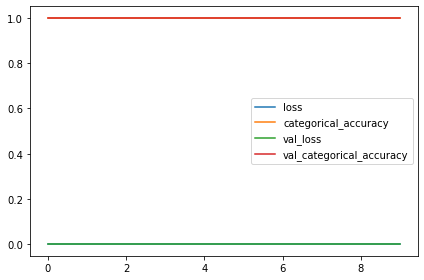

In [40]:
show_history(history_dense_model)

In [45]:
test_gen = DataGenerator(test_x, test_y, batch_size)

# Load best setup
dense_model.load_weights('weights_dense_model.best.hdf5')
pred_y = dense_model.predict(test_gen)

157/157 [==============================] - 1s 5ms/step


In [63]:
# Calculate accuracy on test data
accuracy = calculate_accuracy(pred_y, test_y)
print(f"Accuracy: {round(accuracy, 2) * 100} %")

Accuracy: 100.0 %


### Using Recurrent ANN

In [68]:
# Create checkpoint for storing only best results
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights_recurrent_model.best.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

batch_size = 128
epochs = 10

train_gen = DataGenerator(train_x, train_y, batch_size)
val_gen = DataGenerator(val_x, val_y, batch_size)


# Fit model.
history_recurrent_model = recurrent_model.fit(train_gen, validation_data=val_gen, epochs=epochs, callbacks=[model_checkpoint_callback])

Epoch 1/10
625/625 [==============================] - 35s 56ms/step - loss: 1.1923e-07 - categorical_accuracy: 1.0000 - val_loss: 1.1921e-07 - val_categorical_accuracy: 1.0000
Epoch 2/10
625/625 [==============================] - 35s 56ms/step - loss: 1.1923e-07 - categorical_accuracy: 1.0000 - val_loss: 1.1921e-07 - val_categorical_accuracy: 1.0000
Epoch 3/10
625/625 [==============================] - 34s 54ms/step - loss: 1.1921e-07 - categorical_accuracy: 1.0000 - val_loss: 1.1921e-07 - val_categorical_accuracy: 1.0000
Epoch 4/10
625/625 [==============================] - 35s 56ms/step - loss: 1.1927e-07 - categorical_accuracy: 1.0000 - val_loss: 1.1921e-07 - val_categorical_accuracy: 1.0000
Epoch 5/10
625/625 [==============================] - 36s 58ms/step - loss: 1.1921e-07 - categorical_accuracy: 1.0000 - val_loss: 1.1921e-07 - val_categorical_accuracy: 1.0000
Epoch 6/10
625/625 [==============================] - 36s 57ms/step - loss: 1.1921e-07 - categorical_accuracy: 1.0000 - 

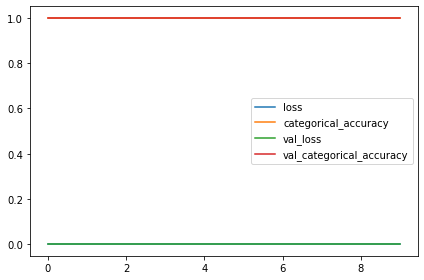

In [69]:
show_history(history_recurrent_model)

In [70]:
test_gen = DataGenerator(test_x, test_y, batch_size)

# Load best setup
recurrent_model.load_weights('weights_recurrent_model.best.hdf5')
pred_y = recurrent_model.predict(test_gen)

157/157 [==============================] - 1s 6ms/step


In [71]:
# Calculate accuracy on test data
accuracy = calculate_accuracy(pred_y, test_y)
print(f"Accuracy: {round(accuracy, 2) * 100} %")

Accuracy: 100.0 %


## Dataset Gutenberg
- Data se skládají z 89 textových souborů, které dohromady tvoří knihu.
- Těchto 89 souborů jsem si rozdělil v poměru 80 : 20 na trénovací a testovací sady.

### Načtení dat

In [20]:
# Load test_x and test_y as bytes from one file
test_x, test_y = load_data_binary("./data/gutenberg/test/47-0.txt", seed=42, lengthOfSubstring=3, portion=1)
test_x = np.array(test_x)
test_y = np.array(test_y)
print(f"\nSize of test dataset: {len(test_y)} [{sys.getsizeof(test_x) + sys.getsizeof(test_y)} B]")

Loading gutenberg dataset [100.0 %]
Size of test dataset: 531878 [2127768 B]


In [20]:
# Load train_x and train_y as bytes
train_x, train_y = load_data_binary("./data/gutenberg/train/*-0.txt", seed=42, lengthOfSubstring=3, portion=0.15)
train_x = np.array(train_x)
train_y = np.array(train_y)
print(f"\nSize of train dataset: {len(train_y)} [{sys.getsizeof(train_x) + sys.getsizeof(train_y)} B]")

Loading gutenberg dataset [100.0 %]
Size of train dataset: 4693698 [18775048 B]


In [21]:
# Split train set into - train and validation set
# WITH shuffle
#train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42, shuffle=True)
# WITHOUT shuffle
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42, shuffle=False)

In [22]:
print(f"Train data: {round(len(train_y) / (len(test_y) + len(train_y) + len(val_y)) * 100, 2) } %")
print(f"Validation data: {round(len(val_y) / (len(test_y) + len(train_y) + len(val_y)) * 100, 2) } %")
print(f"Test data: {round(len(test_y) / (len(test_y) + len(train_y) + len(val_y)) * 100, 2) } %")

Train data: 46.09 %
Validation data: 11.52 %
Test data: 42.38 %


In [23]:
# Size of train, validation and test datasets
print(f"Train set size (X, y): {train_x.shape}, {train_y.shape}")
print(f"Validation set size (X, y): {val_x.shape}, {val_y.shape}")
print(f"Test set size (X, y): {test_x.shape}, {test_y.shape}")

Train set size (X, y): (3754958, 3), (3754958, 1)
Validation set size (X, y): (938740, 3), (938740, 1)
Test set size (X, y): (3452600, 3), (3452600, 1)


In [76]:
# Even further reduce train size. So it doesnt take years.
#train_x, _, train_y, _ = train_test_split(train_x, train_y, test_size=0.8, random_state=42, shuffle=False)

In [77]:
# Size of train, validation and test datasets
#print(f"Train set size (X, y): {train_x.shape}, {train_y.shape}")
#print(f"Validation set size (X, y): {val_x.shape}, {val_y.shape}")
#print(f"Test set size (X, y): {test_x.shape}, {test_y.shape}")

Train set size (X, y): (4520278, 3), (4520278, 1)
Validation set size (X, y): (4520278, 3), (4520278, 1)
Test set size (X, y): (1934011, 3), (1934011, 1)


### Using Dense ANN


In [53]:
# Create checkpoint for storing only best results
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights_dense_model.best.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

batch_size = 1024
epochs = 10

train_gen = DataGenerator(train_x, train_y, batch_size)
val_gen = DataGenerator(val_x, val_y, batch_size)

# Shuffle train data at start of each epoch
# Fit model.
history_dense_model = dense_model.fit(train_gen, validation_data=val_gen, epochs=epochs, callbacks=[model_checkpoint_callback], shuffle=True)

Epoch 1/10
17658/17658 [==============================] - 749s 42ms/step - loss: 1.7748 - categorical_crossentropy: 1.7748 - categorical_accuracy: 0.4786 - val_loss: 1.7758 - val_categorical_crossentropy: 1.7758 - val_categorical_accuracy: 0.4718
Epoch 2/10
17658/17658 [==============================] - 730s 41ms/step - loss: 1.6948 - categorical_crossentropy: 1.6948 - categorical_accuracy: 0.4929 - val_loss: 1.7606 - val_categorical_crossentropy: 1.7606 - val_categorical_accuracy: 0.4736
Epoch 3/10
17658/17658 [==============================] - 785s 44ms/step - loss: 1.6823 - categorical_crossentropy: 1.6823 - categorical_accuracy: 0.4949 - val_loss: 1.7648 - val_categorical_crossentropy: 1.7648 - val_categorical_accuracy: 0.4742
Epoch 4/10
17658/17658 [==============================] - 586s 33ms/step - loss: 1.6764 - categorical_crossentropy: 1.6764 - categorical_accuracy: 0.4957 - val_loss: 1.7565 - val_categorical_crossentropy: 1.7565 - val_categorical_accuracy: 0.4733
Epoch 5/10
1

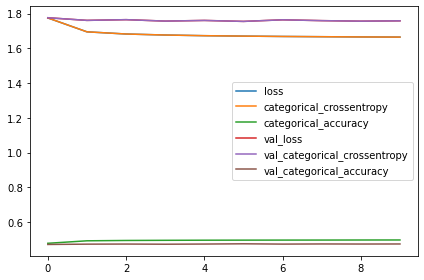

In [54]:
show_history(history_dense_model)

In [55]:
# Save trained weights and biases.
dense_model.save('models/model_dense')

### Using Recurrent ANN

In [24]:
# Create checkpoint for storing only best results
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights_recurrent_model.best.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

batch_size = 1024
epochs = 10

train_gen = DataGenerator(train_x, train_y, batch_size)
val_gen = DataGenerator(val_x, val_y, batch_size)


# Fit model.
history_recurrent_model = recurrent_model.fit(train_gen, validation_data=val_gen, epochs=epochs, callbacks=[model_checkpoint_callback])

Epoch 1/10
3667/3667 [==============================] - 581s 156ms/step - loss: 2.1616 - categorical_crossentropy: 2.1616 - categorical_accuracy: 0.3870 - val_loss: 1.8766 - val_categorical_crossentropy: 1.8766 - val_categorical_accuracy: 0.4576
Epoch 2/10
3667/3667 [==============================] - 573s 156ms/step - loss: 1.8090 - categorical_crossentropy: 1.8090 - categorical_accuracy: 0.4675 - val_loss: 1.7821 - val_categorical_crossentropy: 1.7821 - val_categorical_accuracy: 0.4807
Epoch 3/10
3667/3667 [==============================] - 572s 156ms/step - loss: 1.7396 - categorical_crossentropy: 1.7396 - categorical_accuracy: 0.4838 - val_loss: 1.7526 - val_categorical_crossentropy: 1.7526 - val_categorical_accuracy: 0.4867
Epoch 4/10
3667/3667 [==============================] - 570s 155ms/step - loss: 1.7148 - categorical_crossentropy: 1.7148 - categorical_accuracy: 0.4890 - val_loss: 1.7487 - val_categorical_crossentropy: 1.7487 - val_categorical_accuracy: 0.4872
Epoch 5/10
3667/

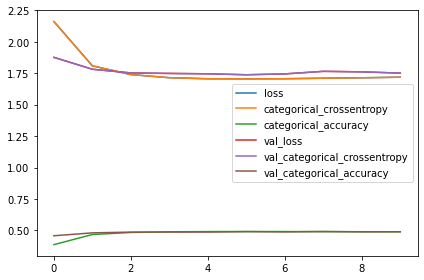

In [25]:
show_history(history_recurrent_model)

In [26]:
# Save trained weights and biases.
recurrent_model.save('models/model_recurrent')

In [21]:
# Load trained model
recurrent_model = tf.keras.models.load_model(r"models/model_recurrent")

In [25]:
# Make predictions on data
test_gen = DataGenerator(test_x, test_y, batch_size)

# Load best setup
recurrent_model.load_weights('weights_recurrent_model.best.hdf5')
pred_y = recurrent_model.predict(test_gen)

520/520 [==============================] - 16s 26ms/step


In [84]:
# Create probability table
probability_table = {}
for i in range(0, 256):
    probabilities = [prediction[0][i] for prediction in pred_y]
    print(f"{int.to_bytes(i, length=1, byteorder='big')}: {np.mean(probabilities)}")
    probability_table[int.to_bytes(i, length=1, byteorder='big')] = np.mean(probabilities).item()
    #print(probabilities)

b'\x00': 1.6955372217353215e-08
b'\x01': 1.7074352598456244e-08
b'\x02': 1.693106987943338e-08
b'\x03': 1.6755979714844216e-08
b'\x04': 1.70504961261031e-08
b'\x05': 1.7056096979217727e-08
b'\x06': 1.7071206670493666e-08
b'\x07': 1.695195095408053e-08
b'\x08': 1.6980489903062335e-08
b'\t': 1.697185503246601e-08
b'\n': 0.019046396017074585
b'\x0b': 1.691066309206235e-08
b'\x0c': 1.6869897478954954e-08
b'\r': 0.01906692609190941
b'\x0e': 1.7020584053284438e-08
b'\x0f': 1.703186569557147e-08
b'\x10': 1.6807140568175782e-08
b'\x11': 1.687139139505689e-08
b'\x12': 1.688018258505508e-08
b'\x13': 1.698325391430444e-08
b'\x14': 1.7040205690932453e-08
b'\x15': 1.6931148039134314e-08
b'\x16': 1.6972881766719183e-08
b'\x17': 1.6993343621152235e-08
b'\x18': 1.6903680233326668e-08
b'\x19': 1.7134620833303416e-08
b'\x1a': 1.6892290233272433e-08
b'\x1b': 1.6942642844242073e-08
b'\x1c': 1.6836478877735317e-08
b'\x1d': 1.689034334617645e-08
b'\x1e': 1.6853309858788634e-08
b'\x1f': 1.7044587963255253e-0

In [78]:
[test_y.reshape(len(test_y))]

[array([b'T', b'h', b'e', ..., b'\n', b'\r', b'\n'], dtype='|S1')]

In [163]:
decimal_precision = 1500

In [164]:
decimal.getcontext().prec = decimal_precision
# Original data
original_data = test_y.reshape(len(test_y))
original_data = original_data
# Create coder
arithmetic_coder = ArithmeticCoder(probability_table=probability_table)
# Encode data
encoded_msg, encoder , interval_min_value, interval_max_value = arithmetic_coder.encode(data=original_data, probability_table=arithmetic_coder.probability_table)

encoded_msg, interval_min_value, interval_max_value

(Decimal('0.2456289323900659482566261042880203518532094200636283646641339565203990374024143881872737964440430567747371360227098918615252613052355095259006356354583048667297510732686319672508588358259684862205413393883527195375400892035304746068361840833633673855944594692640961992878275386642168999684603760444843767321306893597707848758946524854954060947898370691173071586030428022661376292986127364784665557495706471023288387168203418366903006442655637723529963939307735454048508298990476049884268669576694294165576979027056718088838158914978799194761053776835202069876224306804069534337450440301050569338045556357890341208046740364574773358876256402136558190453982462814874459999276504403152302769473334984719627714698801248371215976879793921088312778685136311207383685696918061019916231756556171692113033981616035045747293074999973803411196846898609216155873115829332567489925534556135072847963665150851945856496467113734256418100854126466626241626746881777515412914915508177096375182020350632010

In [165]:
decimal.getcontext().prec = decimal_precision
# Decode data
decoded_msg, decoder = arithmetic_coder.decode(data=encoded_msg, data_length=len(original_data), probability_table=arithmetic_coder.probability_table)
decoded_msg_as_string = "".join([chr(int.from_bytes(x, "big")) for x in decoded_msg])
original_data_as_string = ''.join([chr(int.from_bytes(x, 'big')) for x in original_data])
#print(f"Decoded Message:\t{decoded_msg_as_string}")
#print(f"Original Message:\t{original_data_as_string}")
print("Message Decoded Successfully? {result}".format(result= original_data_as_string == decoded_msg_as_string))

Message Decoded Successfully? False


In [169]:
decoded_msg_as_string

'The Project Gutenberg eBook of Anne Of Avonlea, by Lucy Maud Montgomery\r\n\r\nThis eBook is for the use of anyone anywhere in the United States and\r\nmost other parts of the world at no cost and with almost no restrictions\r\nwhatsoever. You may copy it, give it away or re-use it under the terms\r\nof the Project Gutenberg License included with this eBook or online at\r\nwww.gutenberg.org. If you are not located in the United States, you\r\nwill have to check the laws of the country where you are located before\r\nusing this eBook.\r\n\r\nTitle: Anne Of Avonlea\r\n\r\nAuthor: Lucy Maud Montgomery\r\n\r\nRelease Date: July 2, 1992 [eBook #47]\r\n[Most recently updated: September 7, 2021]\r\n\r\nLanguage: English\r\n\r\nCharacter set encoding: UTF-8\r\n\r\nProduced by: An Anonymous Volunteer and David Widger\r\n\r\n*** START OF THE PROJECT GUTENBERG EBOOK ANNE OF AVONLEA ***\r\n\r\n[Illustration]\r\n\r\n\r\n\r\n\r\nANNE OF AVOMÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿ

In [168]:
# Calculate accuracy on test data
accuracy = calculate_accuracy(pred_y, test_y)
print(f"Accuracy: {round(accuracy, 2) * 100} %")

Accuracy: 49.0 %
